In [1]:
import time
start_time = time.time()

In [2]:
import pandas as pd
import os
from bidi.algorithm import get_display
import re
import multiprocessing

In [3]:
import pickle

In [4]:
file_type = 'thread'
field_name = 'title'

In [5]:
pickle_file = open(f'{file_type}_{field_name}_token_lists.pickle', "rb" )
corpus = pickle.load( pickle_file )
pickle_file.close()

In [6]:
corpus_temp = list()
for sentence in corpus:
    sentence_temp = list()
    for word in sentence:
        try:
            if len(word) > 1:
                sentence_temp.append(get_display(word))
        except:
            print(word)
    corpus_temp.append(' '.join(reversed(sentence_temp)))
corpus = corpus_temp

In [7]:
corpus[0]

'.רוזע וא רזעיהל ,ןיינעתה ואו הנורוק רבשמ לצ תותומע'

In [8]:
##Creating a list of stop words and adding custom stopwords
import codecs
with codecs.open('stopwords.txt', 'r', encoding='utf8') as f:
    text = f.read()
stop_words = set(get_display(word) for word in text.split('\r\n'))

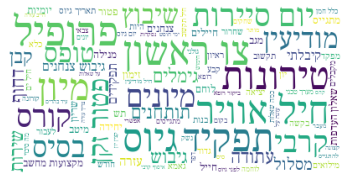

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42,
                          font_path='Fonts/FrankRuhlLibre-Regular.ttf'
                         ).generate(' '.join(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1200)

In [ ]:
new_corpus = list()
for sentence in corpus:
    new_corpus.append(' '.join([word for word in sentence.split() if not word in stop_words]))

In [ ]:
corpus = new_corpus

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(new_corpus)

In [ ]:
list(cv.vocabulary_.keys())[:10]

In [ ]:
import seaborn

In [ ]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [ ]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

In [ ]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[532]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])

In [ ]:
def send_email(user='dsakaidf@gmail.com', pwd='d54k4idf!', recipient='shkasta@post.bgu.ac.il',
               subject='finish expirement', body='finish the expirement'):
    import smtplib

    gmail_user = user
    gmail_pwd = pwd
    FROM = user
    TO = recipient if type(recipient) is list else [recipient]
    SUBJECT = subject
    TEXT = body

    # Prepare actual message
    message = """From: %s\nTo: %s\nSubject: %s\n\n%s
    """ % (FROM, ", ".join(TO), SUBJECT, TEXT)
    try:
        # SMTP_SSL Example
        server_ssl = smtplib.SMTP_SSL("smtp.gmail.com", 465)
        server_ssl.ehlo()  # optional, called by login()
        server_ssl.login(gmail_user, gmail_pwd)
        # ssl server doesn't support or need tls, so don't call server_ssl.starttls()
        server_ssl.sendmail(FROM, TO, message)
        # server_ssl.quit()
        server_ssl.close()
        print('successfully sent the mail')
    except:
        print("failed to send mail")


In [ ]:
send_email()

In [ ]:
elapsed_time = time.time() - start_time
print(elapsed_time)